# Deducing findings from the Data
## Authors

 - Santiago Bernal

## Introduction
In the previous lab exercise, data was gathered from twitter using different hashtags using the Twitter Developer API. The data was then stored in a MongoDB database for later retrieval and analysis. 

In this lab, we will use the data stored in the previous session and explain through a model the findings that can be deduced from the data. The exercise was developed in Python using Jupyter Notebooks.


## Excercise


### Previous lab summary

In the previous lab, we analysed two sets of hashtagas, one included a series of references to Kpop and was heavily influenced by that, and another was more varied and featured mostly political tweets from different countries. In this lab, the second set of data is used. The hashtags relating to it are:

```['#FelizMartes','#ChernobylSky', '#paro', '#PorTuCaraDeMartes', '#TuesdayThoughts', '#5Nov', '#primerapagina', '#SomosTodosAllan', '#BuenMartes', '#UltimaHora', '#Ahora', '#ElectionDay', '#TuesdayMorning', '#DebateElectoral']```

 TuesdayThoughts, 5Nov, BuenMartes, TuesdayMorning. Also it was the same day as a debate in Spain so DebateElectoral was trending and also ElectionDay since there was an election in the US. Some other stuff related to news are: UltimaHora, Ahora and SomosTodosAllan. The last one relates to users expressing support to a journalist in Brazil. 


In [1]:
from __future__ import print_function, division

#General

import os
import json
import string
import operator
import logging
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly as py
import plotly.graph_objs as go
import matplotlib.colors as mcolors

#Mongo

from pymongo import MongoClient
from collections import Counter

#Sentiment Analysis

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from langdetect import detect
from classifier import SentimentClassifier
from string import punctuation

#LDA

import gensim
import pyLDAvis.gensim
import seaborn as sns

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import OrderedDict
from wordcloud import WordCloud, STOPWORDS
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from gensim import corpora, models, similarities



warnings.filterwarnings("ignore")
logging.getLogger("gensim").setLevel(logging.CRITICAL)

init_notebook_mode(connected=True) 

sid = SentimentIntensityAnalyzer()
clf = SentimentClassifier()
nltk.download('vader_lexicon')
# assuming you have mongoDB installed locally
# and a database called 'test'
MONGO_HOST= 'mongodb://localhost/bda1'

# Establish connection with database
client = MongoClient()
db = client.lab1
col2 = db.twitterTest2

/home/santiago/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/santiago/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#######################################################
# Retrieve data from the mongodb database, choosing
# the fields you'll need afterwards
#######################################################
my_tweets = db.twitterTest2.find({},{'lang':1, '_id':0, 'text':1, 'entities.hashtags':1,
'in_reply_to_status_id':1, 'is_quote_status':1, 'retweeted_status':1, 'user.screen_name':1, 
'entities.user_mentions': 1, 'place': 1, '_id': 1, 'extended_tweet':1})
numTweets = db.twitterTest.count_documents(filter={})

The total number of tweets that were able to be retrieve are: 

In [3]:
print('Number of tweets: ', numTweets)

Number of tweets:  106018


After collecting the tweets, we then compare them based on the language detected by twitter:

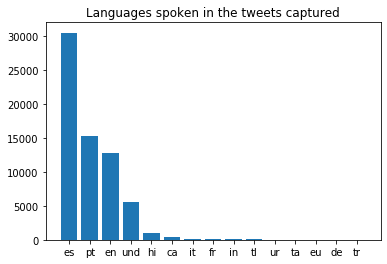

In [4]:
####################################################
# Plot of Languages (autodetected by Twitter)
####################################################
my_tweets.rewind()
langsList = []
for t in my_tweets:
    langsList.append(t['lang'])

D = Counter(langsList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))
# ----------- Bar Plot ------------------------
plt.bar(range(len(subset)), list(subset.values()), align='center')
plt.xticks(range(len(subset)), subset.keys())
plt.title('Languages spoken in the tweets captured')
plt.show()

In this case, most of the tweets were in spanish which makes sense because most of the hashtags used were in spanish. Also a large amount of them were in portuguese which may relate to the SomosTodosAllan hashtag. Coming in third are tweets in english, and then a large amount have undefined language. 

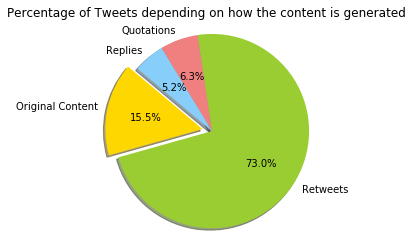

In [5]:
##############################################################
# Plot how many of them are retweets, replies,
# quotations or original tweets
##############################################################
my_tweets.rewind() #Reset cursor
retweets = 0
replies = 0
quotations = 0
originals = 0
for t in my_tweets:
    if t.get('retweeted_status') is not None:
        retweets=retweets+1
    elif t['is_quote_status'] is not False:
        quotations = quotations+1
    elif t.get('in_reply_to_status_id') is not None:
        replies = replies+1
    else:
        originals = originals+1

# ----------- Pie Chart ------------------------
labels = 'Original Content', 'Retweets', 'Quotations', 'Replies'
sizes = [originals, retweets, quotations, replies]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets depending on how the content is generated')
plt.show()

As with before, most of the content was generated by retweets. 

We can then check which hashtag was the most popular of the tweets retrieved

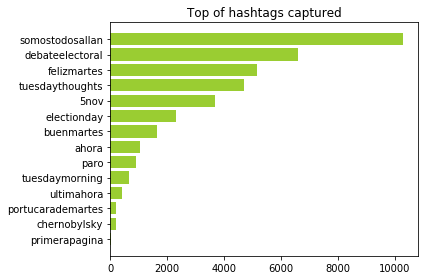

In [6]:
##################################################################
# Plot only filtered hashtags
##################################################################
my_tweets.rewind()
hashList = [] 
words_lower = ['#felizmartes','#paro', '#chernobylsky', '#portucarademartes', '#tuesdaythoughts', '#5nov', '#primerapagina', '#somostodosallan', '#buenmartes', '#ultimahora', '#ahora', '#electionday', '#tuesdaymorning', '#debateelectoral'] 
for t in my_tweets:
    for e in t['entities']['hashtags']:
        if '#' + e['text'].lower() in words_lower or e['text'].lower() in words_lower:
            h = e['text'].lower()
            hashList.append(h)
D = Counter(hashList)
subset = dict(D)
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top of hashtags captured')
plt.tight_layout()
plt.show()

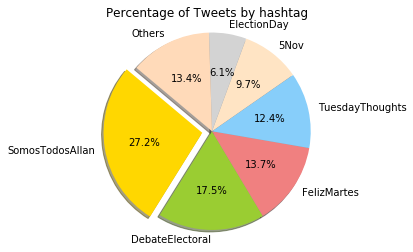

In [7]:
# ----------- Pie Chart ------------------------
others = len(hashList) - subset['somostodosallan'] - subset['debateelectoral'] - subset['felizmartes'] - subset['tuesdaythoughts'] - subset['5nov'] - subset['electionday']
labels = 'SomosTodosAllan', 'DebateElectoral', 'FelizMartes', 'TuesdayThoughts', '5Nov', 'ElectionDay', 'Others'
sizes = [subset['somostodosallan'], subset['debateelectoral'], subset['felizmartes'], subset['tuesdaythoughts'], subset['5nov'], subset['electionday'], others]
frequencies = [x/numTweets for x in sizes]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'bisque', 'lightgrey', 'peachpuff']
explode = (0.1, 0, 0, 0, 0, 0 ,0)  
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Tweets by hashtag')
plt.show()

So the mayority of tweets was with #SomosTodosAllan which represents a 27.2% but now we have a better distribution since the second is #DebateElectoral with 17.5%, and FelizMartes and TuesdayThoughts with 13.7% and 12.4% respectively. 

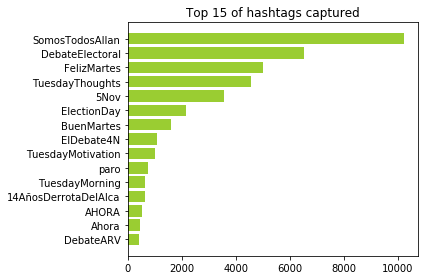

In [8]:
##################################################################
# Plot secondary hashtags
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        h = e['text']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'yellowgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags captured')
plt.tight_layout()
plt.show()

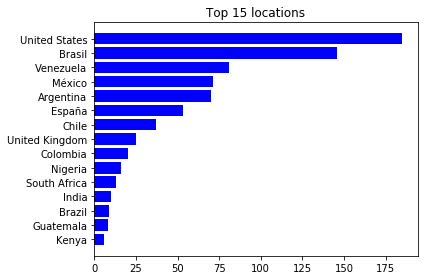

In [9]:
##################################################################
# Plot most common countries
##################################################################
my_tweets.rewind()
geo = []
for t in my_tweets:
    if t['place']: 
        geo.append(t['place']['country'])

D = Counter(geo)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'blue')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 locations')
plt.tight_layout()
plt.show()

The top countries are the US, Brazil and Venezuela. We can look a bit more into this and see which hashtags are popular in each of these top countries 

In [10]:
##################################################################
# Plot countries by hashtags
##################################################################
my_tweets.rewind()
data = []
for t in my_tweets:
    for e in t['entities']['hashtags']:
        if t['place']: 
            d = {'hashtag': e['text'], 'country': t['place']['country']}
            data.append(d)

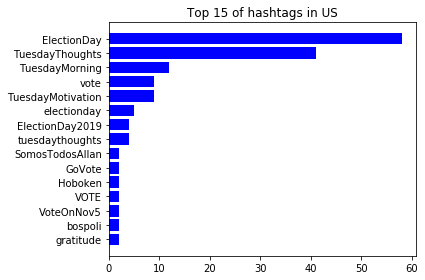

In [11]:
us = []
for d in data:
    if d['country'] == 'United States':
        us.append(d['hashtag'])

D = Counter(us)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'blue')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in US')
plt.tight_layout()
plt.show()

In the US, the most popular hashtag, amongst the tweets that have the location, are the ones in english, with the top one being ElectionDay which was a current event that was transcurring that day, also other variations such as vote, electionday, ElectionDay2019, GoVote, VOTE, VoteOnNov5 were amongst the top 15. The other top are mostly based on the day Tuesday, and a few also related to SomosTodosAllan. 

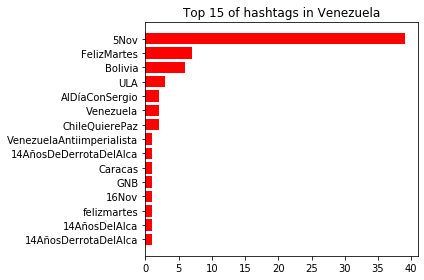

In [12]:
vzla = []
for d in data:
    if d['country'] == 'Venezuela':
        vzla.append(d['hashtag'])

D = Counter(vzla)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'red')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in Venezuela')
plt.tight_layout()
plt.show()

In Venezuela, the most used hashtag was 5Nov by vast majority, and the rest have only a few tweets related. 

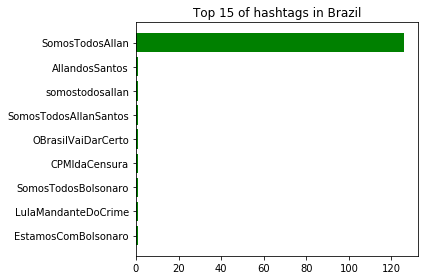

In [13]:
brazil = []
for d in data:
    if d['country'] == 'Brasil':
        brazil.append(d['hashtag'])

D = Counter(brazil)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'green')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of hashtags in Brazil')
plt.tight_layout()
plt.show()

Brazils hashtag was largely dominated by SomosTodosAllan, which makes sense since it was a news that was transcurring in Brazil at the moment. 

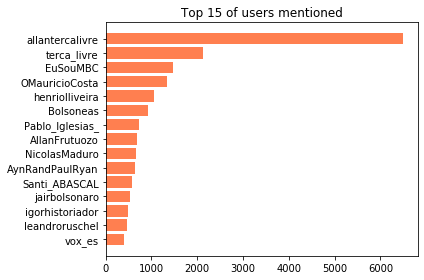

In [14]:
##################################################################
# Plot users mentioned
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        h = e['screen_name']
        hashList.append(h)
D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'coral')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned')
plt.tight_layout()
plt.show()

Out of the users mentioned, most are also related with the hashtags, for example allantercalivre and terca_livre are related to SomosTodosAllan, since they're the media companies that Allan works in. EuSouMBC is a political party in Brazil, and Bolsoneas, OMauricioCosta, henriolliveira and AllanFrutuozo are the twitter account of users that post comedy or political tweets also related to the EuSouMBC party. The account jairbolsonaro is the twitter account for the Brazilian president Jair Bolsonaro. All of them related to the SomosTodosAllan hashtag so most of the users mentioned, specially those in the top 6 are related to this hashtag. 

Pablo_Iglesias_ and Santi_ABASCAL are both political contenders in the Spanish elections, and part of the debate mentioned in the hashtag DebateElectoral. With vox_es being the political party of Santi_ABASCAL. 

NicolasMaduro is the Venezuelan dictador so is probably related to the tweets that came from Venezuela. 

We can also validate these hipothesis by comparing hashtags with users.

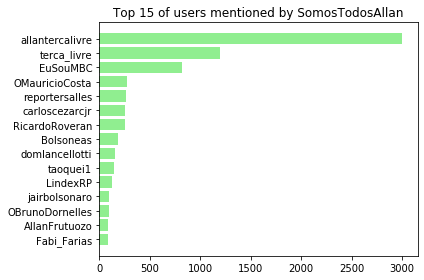

In [15]:
##################################################################
# Plot users mentioned by hashtag: SomosTodosAllan
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if 'SomosTodosAllan' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'lightgreen')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by SomosTodosAllan')
plt.tight_layout()
plt.show()

So as mentioned, most of the users mentioned with the hashtag SomosTodosAllan are those related to the brazilian accounts and politics. 

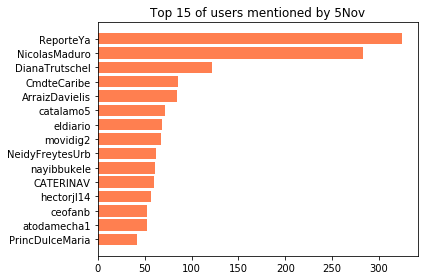

In [16]:
##################################################################
# Plot users mentioned by hashtag: 5Nov
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if '5Nov' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'coral')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by 5Nov')
plt.tight_layout()
plt.show()

Of the top users mentioned in 5Nov was NicolasMaduro, considering that the 5Nov was the most popular hashtag captured for tweets that had location and were in Venezuela. The user is probably mentioned in other hashtags as well, since ReporteYa (a Venezuelan news site) has more mentions in the 5Nov hashtag. 

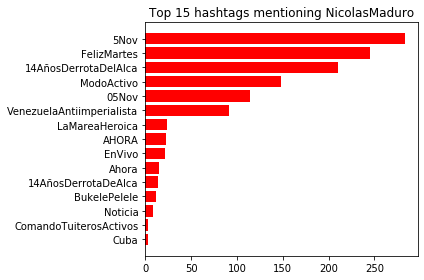

In [17]:
##################################################################
# Plot hashtags for user NicolasMaduro
##################################################################
my_tweets.rewind()
hashList = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if e['screen_name'] == 'NicolasMaduro':
            for h in t['entities']['hashtags']:
                hashList.append(h['text'])

D = Counter(hashList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'red')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 hashtags mentioning NicolasMaduro')
plt.tight_layout()
plt.show()

As mentioned before, NicolasMaduro is also popular in other hashtags captured like "FelizMartes"

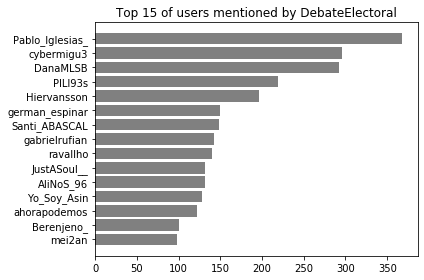

In [18]:
##################################################################
# Plot users mentioned by hashtag: DebateElectoral
##################################################################
my_tweets.rewind()
user = []
for t in my_tweets:
    for e in t['entities']['user_mentions']:
        if 'DebateElectoral' in [e['text'] for e in t['entities']['hashtags']]:
            u = e['screen_name']
            user.append(u)
D = Counter(user)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

# ----------- Horizontal Bar Plot ------------------------
pos = range(len(sorted_subset))
plt.barh(pos, [val[1] for val in sorted_subset], align = 'center', color = 'grey')
plt.yticks(pos, [val[0] for val in sorted_subset])
plt.title('Top 15 of users mentioned by DebateElectoral')
plt.tight_layout()
plt.show()

The DebateElectoral hashtag also has alot of users related to politics like gabrielrufian and ahorapodemos.

## Using models

### Sentiment Analysis

Sentiment analysis allows us to determine the type of interactions the tweets have with the different entities, and gives insights on how topics are being perceived. Sentiments can be positive, negative or neutral (informative) and it reflects the opinions people are expressing towards the entity.

Using the data obtained before, we can review the sentiment users are expressing towards the different entities mentioned in the tweets. For this, we use two pre-trained sentiment analyzer, one for tweets in english (SentimentIntensityAnalyzer), and another for tweets in spanish (SentimentClassifier from https://github.com/aylliote/senti-py). 

We move the data from the cursor to a dataframe, which will make it easier to use with the sentiment analysis and other models. We only retrieve the fields of the data that we want and additionally add a new language detector to compare with twitters automatic language detection. 

In the dataframe, on tweet is stored per row, but, if the tweet has any user mentions, we copy the contents of the tweet to a new row adding the entity, doing this for all the entities, adding a new row for each one. So if the tweet mentions 3 users, then 4 rows are going to be inserted, one without any entity and then one for each user. 

In [19]:

# Move data to a DataFrame
my_tweets.rewind()
#d = list(my_tweets)
tweets = []
for t in my_tweets:
    tweet = {}
    tweet['id'] = str(t['_id'])
    tweet['username'] = t['user']['screen_name']
    
    if t.get('retweeted_status') is not None:
        tweet['type'] = 'retweet'
    elif t['is_quote_status'] is not False:
        tweet['type'] = 'quote_status'
    elif t.get('in_reply_to_status_id') is not None:
        tweet['type'] = 'reply'
    else:
        tweet['type'] = 'original'
        
    if 'extended_tweet' in t:    
        tweet['text'] = t['extended_tweet']['full_text']
    elif 'retweeted_status' in t and 'extended_tweet' in t['retweeted_status']:
        tweet['text'] = t['retweeted_status']['extended_tweet']['full_text']
    else:
        tweet['text'] = t['text']
    
    try:
        tweet['lang'] = detect(tweet['text'])
    except:
        tweet['lang'] = 'und'
        
    tweet['tw_lang'] = t['lang']
    # record with no entity
    tweet['entity'] = ''
    tweets.append(tweet)
    for e in t['entities']['user_mentions']:
        te = tweet.copy()
        te['entity'] = e['screen_name']
        #new record for every entity
        tweets.append(te)
        

Comparing both implementations of language detection, the twitter auto detected have a higher number of undefined, and doesnt detect as many tweets that are in Spanish, so we will use our own implementation for the sentiment analysis.

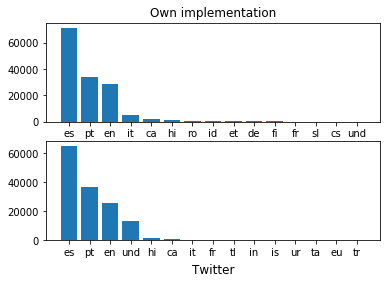

In [20]:
####################################################
# Plot of Languages (autodetected by Twitter)
####################################################
langsList = [t['lang'] for t in tweets]
twlangsList = [t['tw_lang'] for t in tweets]

D = Counter(langsList)
subset = dict(D.most_common(15))
sorted_subset = sorted(subset.items(), key=operator.itemgetter(1))

D = Counter(twlangsList)
subset2 = dict(D.most_common(15))
sorted_subset2 = sorted(subset.items(), key=operator.itemgetter(1))
# ----------- Bar Plot ------------------------
plt.subplot(2,1,1)
plt.bar(range(len(subset)), list(subset.values()), align='center')
plt.xticks(range(len(subset)), subset.keys())
plt.title('Own implementation')
plt.subplot(2,1,2)
plt.bar(range(len(subset2)), list(subset2.values()), align='center')
plt.xticks(range(len(subset2)), subset2.keys())
plt.title('Twitter', y=-0.4)
plt.show()

Some examples like the following are detected differently in each case, these are hard to determine since they mostly contain user mentions and some words in spanish and others in english. For example, it says 'Hello' but also includes spanish hastags like 'BuenMartes'

In [21]:
tweets[6]

{'id': '5dc15f02724b90a85421a52d',
 'username': 'TerapeutaTRE',
 'type': 'reply',
 'text': '@Yesy09752495 @halconavicencio @LuzAngelica_22 @yelarvel @ciprianobracca @luzma04042407 @MagDivina @alejandrator2 ┏━━°❀•°🎀:°•❀°━━┓\n┗━━❀•°:🎀:°• ❀°━━┛\n♡Hello♥\n  🥀🦋🦋#TerapeutaTRE\n💐｡🦋\n🦋@TerapeutaTRE\n💐@halconavicencio\n🦋@LuzAngelica_22\n💐@yelarvel\n🦋@Yesy09752495\n💐@ciprianobracca\n🦋@luzma04042407\n💐@MagDivina\n🦋@alejandrator2\n▶#AngelicsTips\n▶#BuenMartes😊\n🦋💐🦋 https://t.co/Tifb0InQdN',
 'lang': 'es',
 'tw_lang': 'en',
 'entity': 'LuzAngelica_22'}

After obtaining and formatting the tweet, we perform sentiment classification based on the text and the language being used

In [22]:
sentiments = []
for t in tweets:
    if t['lang'] == 'es' :
        t['sentiment'] = clf.predict(t['text'])
        sentiments.append(t)
    elif t['lang'] == 'en': 
        t['sentiment'] = sid.polarity_scores(t['text'])['compound']
        sentiments.append(t)

The result is a score based on the predicted sentiment, where closer to 0 refer to negative sentiment and closer to 1 are positive sentiments

In [23]:
sentiments[20]

{'id': '5dc15f03724b90a85421a53f',
 'username': 'mayread3',
 'type': 'retweet',
 'text': "@realDonaldTrump @MattBevin Wow, what a...packed crowd in Kentucky. 🤣\n\nYour support is waning. People don't want to be seen at your Klan rallies anymore, traitor.\n\n(And yes, this was DURING Trump's speech. Just like it says on that Fox News chyron.) #electionday #virginiavotes #randpaul #tuesdaythoughts https://t.co/ym4bSrRUrL",
 'lang': 'en',
 'tw_lang': 'en',
 'entity': 'AynRandPaulRyan',
 'sentiment': 0.888}

Looking at the overall data, the mean is highly inclined towards negative comments.

In [24]:
df = pd.DataFrame(sentiments)
df.describe()

,sentiment
count,100300.000000
mean,0.229957
std,0.318333
min,-0.972300
25%,0.017315
50%,0.124979
75%,0.447857
max,0.996963


In [25]:
## save dataframe to file for easy retrieval
df.to_csv('tweets_dataframe.csv')

In [26]:
## retrieve dataframe if not loaded
df = pd.read_csv('tweets_dataframe.csv')

In [27]:
# top mentions 
df['entity'].value_counts().nlargest(10)

Pablo_Iglesias_    719
allantercalivre    682
AynRandPaulRyan    631
NicolasMaduro      599
Santi_ABASCAL      573
vox_es             392
realDonaldTrump    340
ReporteYa          326
Maria_Marione      311
sanchezcastejon    302
Name: entity, dtype: int64

We can view the amount of negative, positive, or neutral sentiments being expressed towards each of the top entities. Most of them are political figures and usually political commentary can be mostly negative than positive, as its shown in this sample of tweets captured

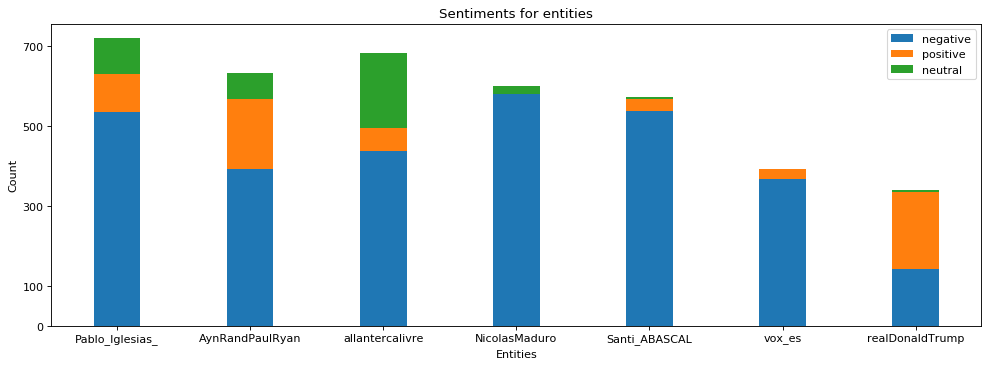

In [28]:
header = ['negative','positive', 'neutral']
positives = (df[(df['entity']=='Pablo_Iglesias_') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='AynRandPaulRyan') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='allantercalivre') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='NicolasMaduro') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='Santi_ABASCAL') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='vox_es') & (df['sentiment'] > 0.65)].count()[0],
             df[(df['entity']=='realDonaldTrump') & (df['sentiment'] > 0.65)].count()[0])

negatives = (df[(df['entity']=='Pablo_Iglesias_') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='AynRandPaulRyan') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='allantercalivre') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='NicolasMaduro') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='Santi_ABASCAL') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='vox_es') & (df['sentiment'] < 0.45)].count()[0],
             df[(df['entity']=='realDonaldTrump') & (df['sentiment'] < 0.45)].count()[0])

neutral = (df[(df['entity']=='Pablo_Iglesias_') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='AynRandPaulRyan') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='allantercalivre') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='NicolasMaduro') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='Santi_ABASCAL') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='vox_es') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0],
           df[(df['entity']=='realDonaldTrump') & (df['sentiment'] <= 0.65) & (df['sentiment'] >= 0.45)].count()[0])


N = 7
ind = np.arange(N)
width = 0.35

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
p1 = plt.bar(ind, negatives, width)
p2 = plt.bar(ind, positives, width,
             bottom=negatives)
p3 = plt.bar(ind, neutral, width,
             bottom=np.array(positives)+np.array(negatives))

plt.ylabel('Count')
plt.xlabel('Entities')
plt.title('Sentiments for entities')
plt.xticks(ind, ('Pablo_Iglesias_','AynRandPaulRyan', 'allantercalivre', 'NicolasMaduro',
                'Santi_ABASCAL','vox_es','realDonaldTrump'))
plt.yticks([0, 100, 300, 500, 700])
plt.legend((p1[0], p2[0], p3[0]), ('negative', 'positive', 'neutral'))

plt.show()

### Latent Dirichlet Allocation (LDA)

Introduced by [David Blei, Andrew Ng and Michael Jordan (2003)](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf), LDA is a generative statistical model that is commonly used for Topic modelling, which is able to find abstract "topics" that occur in a corpus. Different to a bag of words (BOW), where each document is mapped to the tokens (document-term or term-document matrix); in LDA, "latent variables" (topics) are introduced as bridges, and the documents are mapped to the topic, and each topic to the corresponding tokens. 

With LDA we can achieve dimensionality reduction on large datasets by grouping familiar information, which could help in analysis of the data as well as for later use in a supervised learning model.

In the previous lab we assumed some of the topics that were going on in the tweets by manually analysing some of the content and the users involved. By using this topic modelling technique, we can find out what the tweets are mostly about without having to look deep into the data or do any previous analysis. 

To perform LDA, we start by building the corpus. We only use tweets in english for this experiment. Also, when building the dataframe, we added repeated values for tweets that mentioned multiple users to be able to extract the sentiment expressed to each one, in this case, we wont need those extra tweets as they may affect the topic modelling, giving more relevance to tweets that mention multiple users.

In [29]:
## build a corpus with only the text in english
without_duplicates = df.drop_duplicates(subset='id', keep="last")
corpus = without_duplicates[without_duplicates['lang'] == 'en']['text'].tolist()

We use nltk to remove any common words, we also define a list of additional words to remove, and finally we remove any punctuations. 
The text is later transformed to gensim dictionary. [gensim](https://radimrehurek.com/gensim/about.html) is a library that helps to realize unsupervised semantic modelling from plain text. 

In [30]:
# removing common words and tokenizing
list1 = ['RT','rt', '&amp;', '\n', "it's"]
stoplist = stopwords.words('english') + list(punctuation) + list1

texts = [[word.translate(str.maketrans('', '', string.punctuation)) for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)


The doc2bow method of the dictionary is then used to convert the document into a Bag of Words. 

In [31]:
corpus_bow = [dictionary.doc2bow(text) for text in texts]

Then a Tfidf model is initialized using the corpus, and then use the model to transform the vectors. With that, we can start building the LDA model, which expects the corpus as a bag of words, the dictionary built previously, and a amount of topics. Then the tfidf corpus is passed to the model, and we obtain the corpus for the LDA.


In [32]:
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]  


total_topics = 4
lda = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]
#lda.show_topics(total_topics,5)

If we view some of the topics, most are about the day that the tweets were received ("tuesdaythoughts", "tuesdaymotivation") and others about the election ("electionday", "vote"). As mentioned in the previous lab, these where the events going on in that day, and additionally corresponds to some of the hashtags used to filter the tweets that were stored. Also some are related to political parties as well, such as republicans and democrats

In [33]:
lda.print_topics(4)

[(0,
  '0.033*"tuesdaythoughts" + 0.010*"texas" + 0.008*"income" + 0.007*"electionday2019" + 0.007*"gun" + 0.006*"tuesdaymotivation" + 0.006*"it’s" + 0.005*"god" + 0.005*"ballot" + 0.005*"never"'),
 (1,
  '0.030*"tuesdaythoughts" + 0.015*"statewide" + 0.011*"tuesdaymotivation" + 0.010*"la" + 0.010*"virginia" + 0.010*"tuesdaymorning" + 0.008*"va" + 0.008*"ms" + 0.007*"ky" + 0.006*"across"'),
 (2,
  '0.071*"vote" + 0.045*"electionday" + 0.031*"today" + 0.019*"tuesdaythoughts" + 0.017*"election" + 0.014*"elections" + 0.011*"🗳" + 0.009*"local" + 0.008*"state" + 0.008*"virginia"'),
 (3,
  '0.025*"tuesdaythoughts" + 0.020*"electionday" + 0.013*"polls" + 0.012*"rights" + 0.012*"republican" + 0.009*"know" + 0.009*"open" + 0.008*"family" + 0.008*"find" + 0.007*"new"')]

## Visualization

We can obtain a dataframe from the resulting representation of the topics, and view how some words are related

In [34]:
data_lda = {i: OrderedDict(lda.show_topic(i,10)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
#print(df_lda.shape)
df_lda

,tuesdaythoughts,texas,income,electionday2019,gun,tuesdaymotivation,it’s,god,ballot,never,...,local,state,polls,rights,republican,know,open,family,find,new
0,0.033324,0.009826,0.008304,0.007393,0.007122,0.006451,0.005635,0.0051,0.005039,0.004623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.029921,0.000000,0.000000,0.000000,0.000000,0.011277,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.018534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.009148,0.008045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.025053,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.013473,0.011874,0.011695,0.009023,0.008543,0.008033,0.007767,0.007165


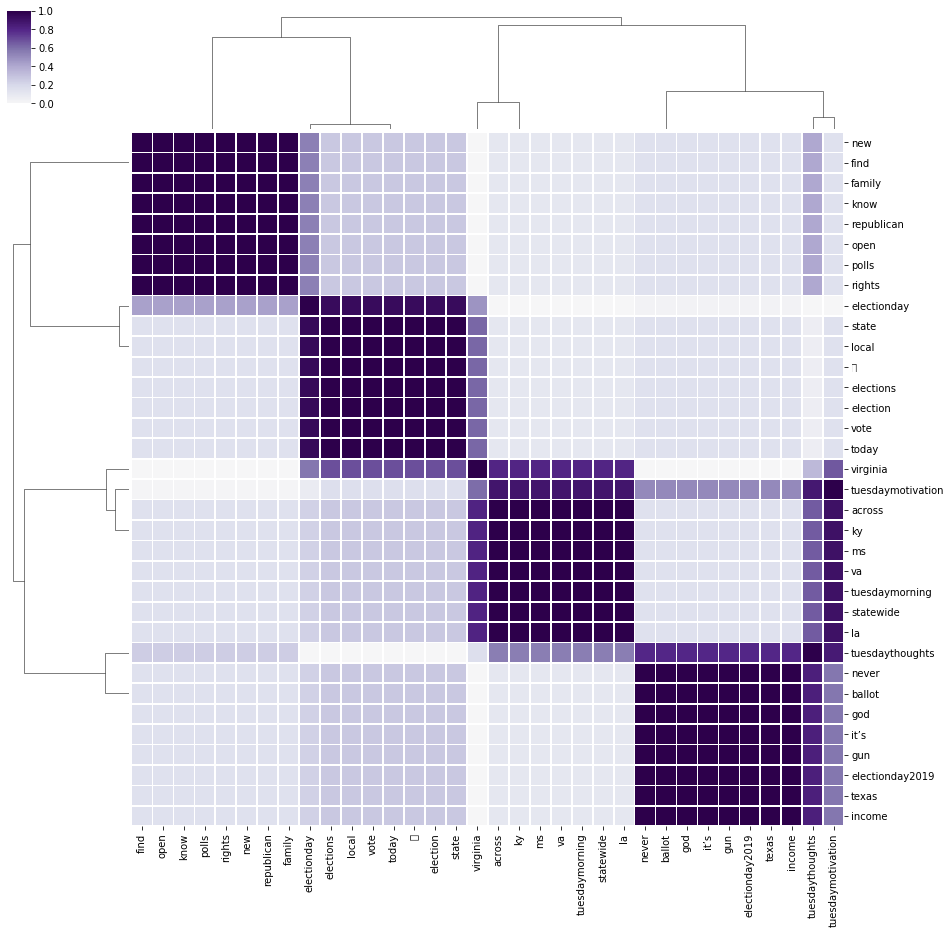

In [35]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="PuOr", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

The correlation matrix can give us a bit of guidance into where tokens are being grouped into topics, but it is not very intuitive, so we can look for additional forms of visualising the data. 

Each document is composed of multiple topics, but only one topic is dominant, we can visualize this topic for some sentences and the keywords

In [36]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_lda):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(corpus):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['DominantTopic', 'TopicContrib%', 'Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [37]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus_lda, texts=texts)

# Format`
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document#', 'DominantTopic', 'TopicContrib%', 'Keywords', 'Sentence']
df_dominant_topic

,Document#,DominantTopic,TopicContrib%,Keywords,Sentence
0,0,3.0,0.8809,"tuesdaythoughts, electionday, polls, rights, r...","[realdonaldtrump, mattbevin, wow, apacked, cro..."
1,1,3.0,0.8809,"tuesdaythoughts, electionday, polls, rights, r...","[realdonaldtrump, mattbevin, wow, apacked, cro..."
2,2,0.0,0.8745,"tuesdaythoughts, texas, income, electionday201...","[one, favorite, questions, african, feminists,..."
3,3,0.0,0.5272,"tuesdaythoughts, texas, income, electionday201...","[im, always, happy, see, manifestations, love,..."
4,4,1.0,0.8151,"tuesdaythoughts, statewide, tuesdaymotivation,...","[realise, it’s, tuesday, it’s, already, long, ..."
...,...,...,...,...,...
14093,14093,2.0,0.8153,"vote, electionday, today, tuesdaythoughts, ele...","[tiptondems, hey, mississippi, it’s, electiond..."
14094,14094,0.0,0.8730,"tuesdaythoughts, texas, income, electionday201...","[tuesdaythoughts, trumpanistas, wearing, read,..."
14095,14095,3.0,0.8394,"tuesdaythoughts, electionday, polls, rights, r...","[staring, human, nice, tuna, breakfast, 😼😹, wo..."
14096,14096,1.0,0.5197,"tuesdaythoughts, statewide, tuesdaymotivation,...","[set, today, lets, work, hard, choose, make, p..."


Additionally, with the dataframe created before, we can also obtain the most representative sentence of the topic out of the sample of sentences used, for the case of the tweets it seems its mostly determined by the users being mentioned.

In [38]:
#pd.reset_option('all')

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('DominantTopic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['TopicContrib%'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic#', "TopicContrib%", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic#,TopicContrib%,Keywords,Representative Text
0,0.0,0.8840,"tuesdaythoughts, texas, income, electionday201...","[lepapillionblue, sdrmedco, bcool333, simplyju..."
1,1.0,0.9167,"tuesdaythoughts, statewide, tuesdaymotivation,...","[lisatruthjohns, nikhil63870659, humbleindian,..."
2,2.0,0.8962,"vote, electionday, today, tuesdaythoughts, ele...","[lsoubranne, sami1231sami11, eggmarkus, 3myria..."
3,3.0,0.8809,"tuesdaythoughts, electionday, polls, rights, r...","[realdonaldtrump, mattbevin, wow, apacked, cro..."


A wordcloud can also be made to view the keywords better, it seems the topics where group by 3 referring to the day: "tuesdaythoughts" and one on the election with "vote" and "electionday". Internally, some of the "tuesdaythoughts" topics also have in different representation size other words, one relates to "electionday" and "repulican", another uses "statewide" and "virginia" and finally the other "tuesdaythoughts" topic has "texas" all refering to states in the US.

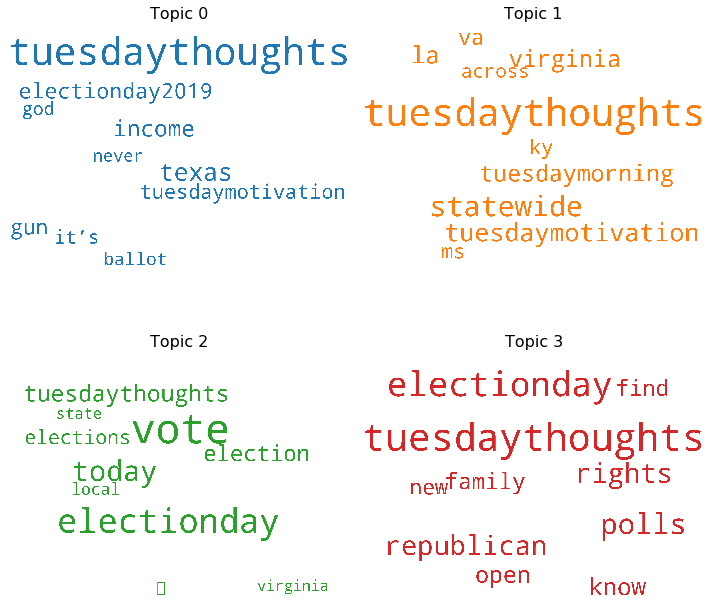

In [39]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stoplist,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Additionally, we can build a clustering chart of the documents using t-distributed stochastic neighbor embedding, and view the separation of the different topics with the help of PCA. It can be seen that the topics share a lot of the representation space and the separation is not so clear in many areas.

In [42]:
# Get topic weights and dominant topics ------------

# Get topic weights
topic_weights = []
for i, row_list in enumerate(corpus_lda):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
#arr = arr[np.amax(arr, axis=1) > 0.1]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...

An image of the result is added since the graph is not rendered when exporting to pdf:

![Clustering of topics](tsne.png)

Using [LDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb) we can visualize better the top topics, as mentioned in their [documentation](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf), they use the following notation:
* D = documents in the corpus
* nd = tokens in document d, for d = 1...D
* N = sum of total tokens in the corpus
* W = terms in the vocabulary
* Mw = the frequency of term w across the corpus, where sum of all Mw = N
* K = amount of topics in the model

The visual elements correspond to the following:
1. Default Topic Circles (Blue Circles): K circles, one to represent each topic, whose areas are set to be proportional to the proportions of the topics across the N total tokens in the corpus. The default topic circles are displayed when no term is highlighted.

2. Red Bars: K×W red horizontal bars, each of which represents the estimated number of times a given term was generated by a given topic. When a topic is selected, we show the red bars for the R most relevant terms for the selected topic, where R = 30 by default (see Sievert and Shirley (2014) for the definition of relevance).

3. Blue Bars: W blue horizontal bars, one to represent the overall frequency of eachterm in the corpus. When no topic is selected, we display the blue bars for the R most salient terms in the corpus, and when a topic is selected, we display the blue bars for the R most relevant terms. See Chuang et al. (2012) for the definition of the saliency of a term in a topic model.

4. Topic-Term Circles: K × W circles whose areas are set to be proportional to the frequencies with which a given term is estimated to have been generated by the topics. When a given term, w, is highlighted, the K default circles transition (i.e. their areas change) to the K topic-term circles for term w

In [41]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  62.492519
2        1.782994 -295.079681       2        1  12.508374
1      220.811432 -343.832123       3        1  12.500029
0       50.533993  -76.050934       4        1  12.499081, topic_info=     Category        Freq             Term       Total  loglift  logprob
326   Default  129.000000             vote  129.000000  30.0000  30.0000
5     Default  264.000000      electionday  264.000000  29.0000  29.0000
23    Default  364.000000  tuesdaythoughts  364.000000  28.0000  28.0000
301   Default   75.000000            today   75.000000  27.0000  27.0000
449   Default   33.000000         election   33.000000  26.0000  26.0000
...       ...         ...              ...         ...      ...      ...
3088   Topic4    5.169936             turn    7.980555   1.6454  -5.8315
63     Topic4    6.156016              see   16.859278   1.0720  -5.6569
129    Topic4    7.583129   tuesdaymorning   52.377319   0.1470  -5.4484
309    Topic4    5.047431           hawaii   13.977656   1.0609  -5.8555
208    Topic4    5.370351             know   89.442436  -0.7332  -5.7935

[299 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
15799      4  0.883666  0werewolf0
20418      3  0.896840         10n
445        2  0.951377           3
1504       2  0.939798           4
446        2  0.791185         76k
...      ...       ...         ...
18589      1  0.986607          ✉️
15822      4  1.004481           🎥
331        2  0.974776           🗳
311        4  0.973118           😒
18484      1  0.973589      🚨today

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

An image of the result is added since the map is not rendered when exporting to pdf:

![Image of pyLDAvis](ldavis.png)

The first topic, having 62.5% of the total tokens, refers to "tuesdaythoughts" and "electionday", the rest of the topics possess 12.5% each and are, in order from 2 to 4: about "vote" and "electionday", about "tuesdaythoughts" and "statewide" and finally "tuesdaythoughts" and "texas". This was also able to be viewed in the WordCloud, but with this tool we can see the frequency of the terms more clearly. 


## Conclusion

By using models we can find insights in the data that may be hard to find if analysed manually. In this exercise we used LDA which allowed us to find relevant topics that are being discussed in a corpus. Even though for this example a lot of the topics were related to the hashtags, if the search for tweets had been random, or if the hashtags were not known, this would be one way that they could be obtained. Additionally, new topics related to the hashtag were also found, which gave a bit more knowledge about the tweets, like "vote" and "polls". The separation between topics would probably have been better if more hashtags were used that included events transcurring in english (since the other languages where filtered out).

Also, different techniques can also be used on the data to find more information about it, like sentiment analysis, which can show us how users are perceiving the different topics and entities being involved in the text.